In [1]:
# Import Libraries
import pandas as pd
import numpy as np
from pathlib import Path
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Patch

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import FunctionTransformer
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from scipy.stats import loguniform, uniform
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV

In [5]:
# Load training and test data.

DATA_DIR = Path('.')
train_df = pd.read_csv(DATA_DIR / 'data/appartments_train.csv')
test_df  = pd.read_csv(DATA_DIR / 'data/appartments_test.csv')
print(f"Train shape: {train_df.shape} | Test shape: {test_df.shape}\n")

Train shape: (156454, 34) | Test shape: (39114, 33)



In [4]:
# Convert src_month to datetime for time based operations.
train_df["src_month"] = pd.to_datetime(train_df["src_month"])
test_df["src_month"]  = pd.to_datetime(test_df["src_month"])

C:\Users\chukw.DESKTOP-AMQ2FJB\AppData\Local\Temp\ipykernel_8404\2991213763.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  train_df["src_month"] = pd.to_datetime(train_df["src_month"])


In [5]:
# View the summary statistics
summary_stats = train_df.describe().T
display(summary_stats) 

,count,mean,min,25%,50%,75%,max,std
dim_m2,156454.0,58.702447,18.78,42.24,54.24,69.82,187.31,23.278725
n_rooms,156454.0,2.678634,1.0,2.0,3.0,3.0,6.0,0.916015
floor_no,128756.0,3.334749,1.0,2.0,3.0,4.0,29.0,2.535675
floor_max,154533.0,5.312859,1.0,3.0,4.0,6.0,29.0,3.311659
year_built,130741.0,1986.010532,1850.0,1967.0,1994.0,2016.0,2024.0,33.792722
dist_centre,156454.0,4.357027,0.008,2.0,3.935,6.128,19.686,2.90058
n_poi,156454.0,20.611509,0.0,7.0,14.0,24.0,212.0,24.212745
dist_sch,156324.0,0.413302,0.002,0.174,0.288,0.469,5.718,0.46938
dist_clinic,155883.0,0.970588,0.001,0.353,0.669,1.245,5.818,0.901307
dist_post,156266.0,0.516677,0.001,0.236,0.392,0.623,5.864,0.505063


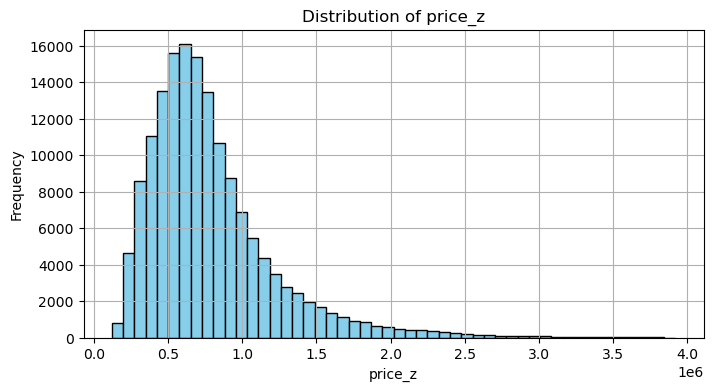

In [6]:
# Distribution of the target variable 'price_z'
plt.figure(figsize=(8, 4))
plt.hist(train_df['price_z'].dropna(), bins=50, color='skyblue', edgecolor='black')
plt.title('Distribution of price_z')
plt.xlabel('price_z')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

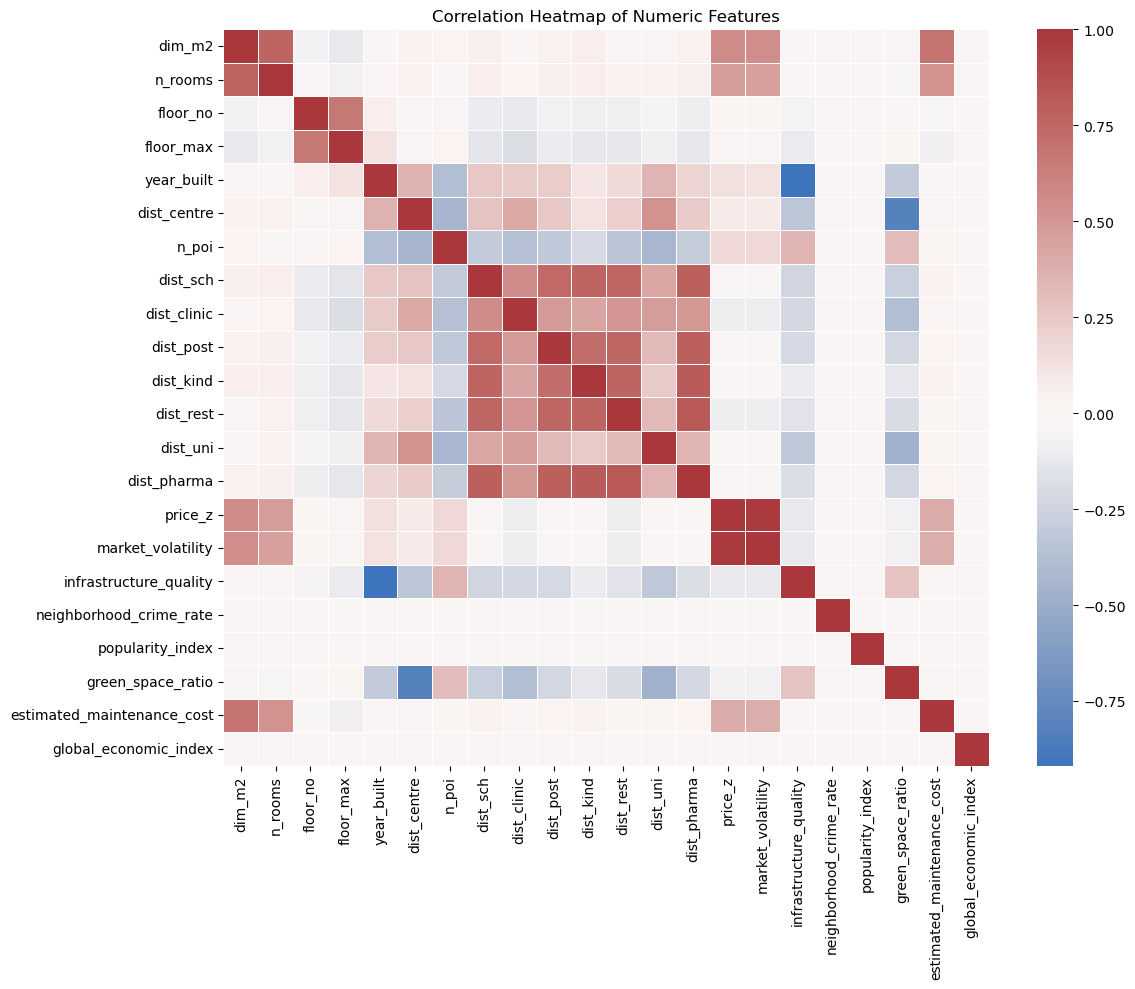

In [7]:
# Correlation heatmap of numeric features
numeric_cols = train_df.select_dtypes(include=[np.number]).columns.tolist()

plt.figure(figsize=(12, 10))
corr_matrix = train_df[numeric_cols].corr()
sns.heatmap(corr_matrix, cmap='vlag', center=0, annot=False, fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap of Numeric Features")
plt.tight_layout()
plt.show()


##### No extreme collinearity; dim_m2 and n_rooms are moderately correlated (≈0.6). price_z correlates most with market_volatility, loc_price_roll3, and dim_m2.


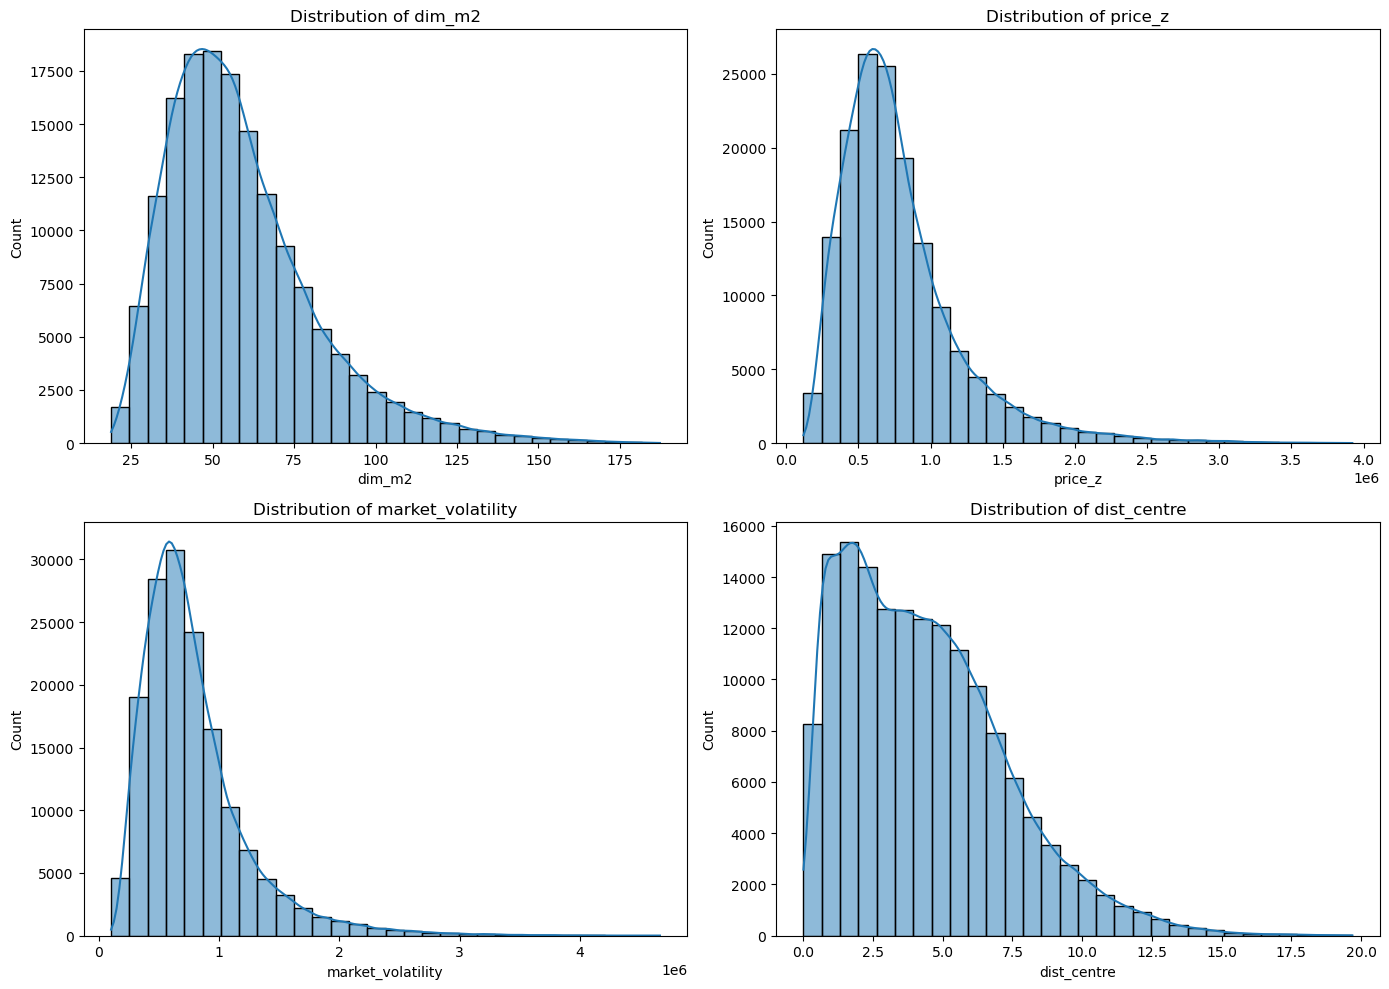

In [10]:
# Histograms of key numeric variables
key_vars = ['dim_m2', 'price_z', 'market_volatility', 'dist_centre']
plt.figure(figsize=(14, 10))
for i, var in enumerate(key_vars, 1):
    plt.subplot(2, 2, i)
    sns.histplot(train_df[var].dropna(), kde=True, bins=30)
    plt.title(f"Distribution of {var}")
plt.tight_layout()
plt.show()

##### dim_m2 and price_z are right-skewed: many small flats, few very large ones. market_volatility is nearly symmetric; dist_centre shows a long tail.Log transforms on distances help compress that tail.


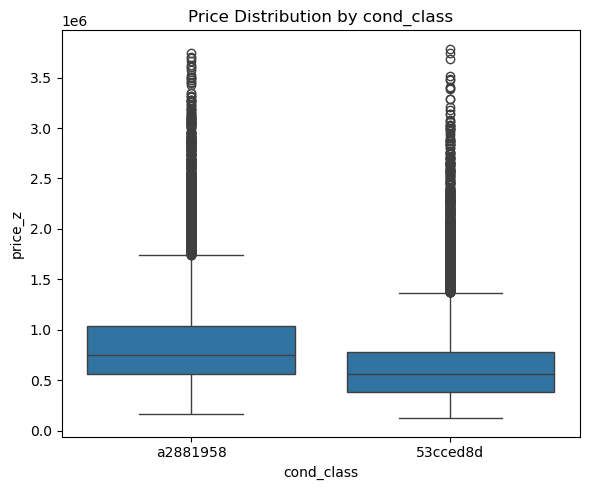

In [12]:
# Boxplot: price_z by cond_class
plt.figure(figsize=(6, 5))
sns.boxplot(x='cond_class', y='price_z', data=train_df)
plt.title("Price Distribution by cond_class")
plt.tight_layout()
plt.show()

##### a2881958 has the widest and highest price range. 53cced8d sits lower.

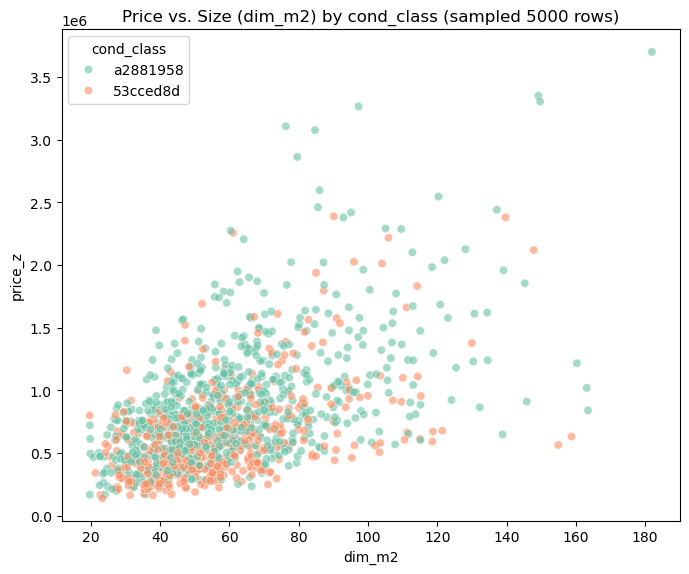

In [17]:
# Scatter plot: price_z vs dim_m2, colored by cond_class
plt.figure(figsize=(7, 6))
sns.scatterplot(x='dim_m2', y='price_z', hue='cond_class', alpha=0.6, palette='Set2', data=train_df.sample(5000, random_state=42))
plt.title("Price vs. Size (dim_m2) by cond_class (sampled 5000 rows)")
plt.xlabel("dim_m2")
plt.ylabel("price_z")
plt.tight_layout()
plt.show()

##### Relationship is roughly linear up to ~120 m², then flattens. The Colour confirms cond_class a2881958 dominates the high-price end.

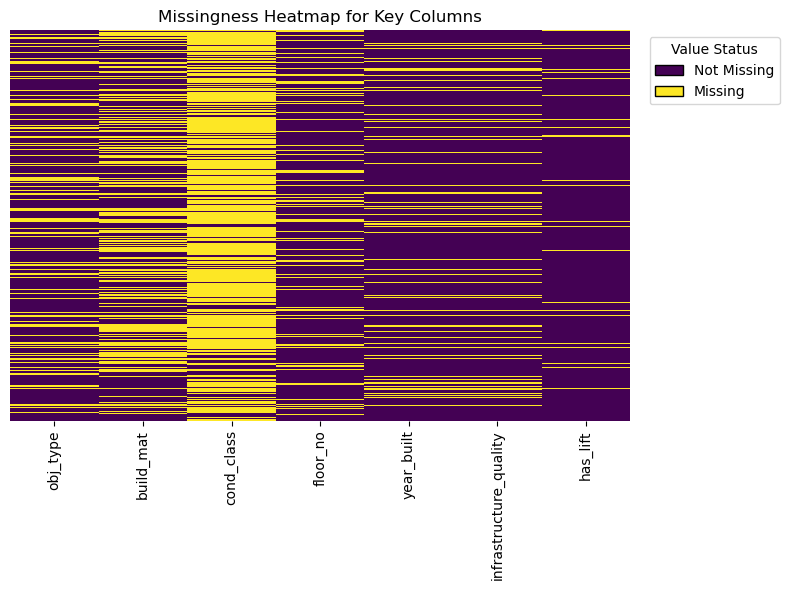

In [20]:
# Missingness heatmap for a subset of columns
missing_cols = [
    'obj_type', 'build_mat', 'cond_class',
    'floor_no', 'year_built',
    'infrastructure_quality', 'has_lift'
]
missing_matrix = train_df[missing_cols].isnull()
cmap = plt.cm.viridis
color_not_missing = cmap(0.0)  # for False (not missing)
color_missing     = cmap(1.0)  # for True (missing)
discrete_cmap     = sns.color_palette([color_not_missing, color_missing])

plt.figure(figsize=(8, 6))
sns.heatmap(
    missing_matrix,
    cmap=discrete_cmap,
    cbar=False,
    yticklabels=False
)
plt.title("Missingness Heatmap for Key Columns")

legend_handles = [
    Patch(facecolor=color_not_missing, edgecolor='black', label='Not Missing'),
    Patch(facecolor=color_missing,     edgecolor='black', label='Missing')
]
plt.legend(
    handles=legend_handles,
    title="Value Status",
    bbox_to_anchor=(1.02, 1),
    loc='upper left'
)

plt.tight_layout()
plt.show()

##### About one third of rows are missing in cond_class and build_mat; lift info is patchy. These gaps justify the missing flags and imputations we will add later on.


In [23]:
# 2. Frequency-encode high-cardinality columns
HIGH_CARD = ['loc_code', 'obj_type', 'build_mat']
for col in HIGH_CARD:
    freq = train_df[col].value_counts(normalize=True)
    train_df[f'{col}_freq'] = train_df[col].map(freq).fillna(0)
    test_df[f'{col}_freq']  = test_df[col].map(freq).fillna(0)
    train_df.drop(columns=[col], inplace=True)
    test_df.drop(columns=[col],  inplace=True)

In [24]:
def convert_booleans(df):
    bool_cols = ['has_park', 'has_balcony', 'has_lift', 'has_sec', 'has_store']
    for c in bool_cols:
        if c in df:
            df[c] = df[c].replace('nan', pd.NA).map({'True': True, 'False': False})
            df[c] = df[c].fillna(False).astype('object')
    return df

In [25]:
def preprocess_missing_flags(df):
    df = df.copy()
    df = convert_booleans(df)
    # cond_class missing
    df['cond_class_missing'] = df['cond_class'].isna().astype(int)
    df['cond_class'] = df['cond_class'].fillna('missing')
    # numeric missing flags + impute
    for c in ['floor_no','year_built','infrastructure_quality']:
        df[f'{c}_missing'] = df[c].isna().astype(int)
        df[c] = df[c].fillna(df[c].median())
    return df

In [26]:
def add_engineered_features(df):
    df = preprocess_missing_flags(df)
    out = df.copy()
    out['age'] = 2025 - out['year_built']
    out['rel_floor'] = out['floor_no'] / out['floor_max'].replace(0, np.nan)
    out['room_size_avg'] = out['dim_m2'] / out['n_rooms'].replace(0, np.nan)
    for c in [col for col in out if col.startswith('dist_')] + ['dist_centre']:
        out[f'log_{c}'] = np.log1p(out[c])
    return out

In [27]:
# apply to both sets
train_df = add_engineered_features(train_df)
test_df  = add_engineered_features(test_df)

C:\Users\chukw.DESKTOP-AMQ2FJB\AppData\Local\Temp\ipykernel_8404\1844729783.py:6: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[c] = df[c].fillna(False).astype('object')
C:\Users\chukw.DESKTOP-AMQ2FJB\AppData\Local\Temp\ipykernel_8404\1844729783.py:6: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[c] = df[c].fillna(False).astype('object')
C:\Users\chukw.DESKTOP-AMQ2FJB\AppData\Local\Temp\ipykernel_8404\1844729783.py:6: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call re

In [28]:
# 4. Sort by month for time-aware splitting
train_df['src_month_dt'] = pd.to_datetime(train_df['src_month'], errors='coerce')
train_df = train_df.sort_values('src_month_dt').drop(columns=['src_month_dt'])

In [29]:
# Build feature lists
TARGET = 'price_z'

bool_cols = [
    c for c in train_df.columns
    if train_df[c].dtype == 'object' and train_df[c].isin([True, False]).all()
]

num_cols = [
    c for c in train_df.select_dtypes(include=[float, int]).columns
    if c != TARGET
]

all_obj_cols = [
    c for c in train_df.select_dtypes(include=['object']).columns
    if c not in bool_cols
]

cheap_ohe = []
for c in all_obj_cols:
    if c in ['cond_class', 'own_type']:
        n_levels = train_df[c].nunique()
        if n_levels <= 10:
            cheap_ohe.append(c)

cat_cols = cheap_ohe.copy()

for c in cat_cols:
    if c in num_cols:
        num_cols.remove(c)

print("bool_cols:", bool_cols)
print("num_cols: (first 10)", num_cols[:10], "... (total", len(num_cols), ")")
print("cat_cols:", cat_cols)


bool_cols: ['has_park', 'has_balcony', 'has_lift', 'has_sec', 'has_store']
num_cols: (first 10) ['dim_m2', 'n_rooms', 'floor_no', 'floor_max', 'year_built', 'dist_centre', 'n_poi', 'dist_sch', 'dist_clinic', 'dist_post'] ... (total 39 )
cat_cols: ['own_type', 'cond_class']


In [30]:
# Define preprocessor
numeric_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler',  StandardScaler()),
])

categorical_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot',  OneHotEncoder(handle_unknown='ignore', sparse_output=True)),
])

boolean_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num',  numeric_pipe,   num_cols),
        ('cat',  categorical_pipe, cat_cols),
        ('bool', boolean_pipe,  bool_cols),
    ],
    remainder='drop'
)


In [31]:
#  Define X and y
X = train_df.drop(columns=[TARGET])
y = train_df[TARGET]

In [32]:
# Hyperparameter distributions for HGB
hgb_param_dist = {
    'model__learning_rate': loguniform(1e-3, 0.3),
    'model__max_iter': [100, 200, 500],
    'model__max_leaf_nodes': [15, 31, 63],
    'model__min_samples_leaf': [20, 50, 100],
}

from sklearn.preprocessing import FunctionTransformer

hgb_pipe = Pipeline([
    ('prep', preprocessor),
    ('to_dense', FunctionTransformer(
        func=lambda X: X.toarray() if hasattr(X, "toarray") else X,
        accept_sparse=True
    )),
    ('model', HistGradientBoostingRegressor(random_state=42))
])


In [33]:
# Randomized search on a 30k sample
search_hgb = RandomizedSearchCV(
    hgb_pipe,
    param_distributions=hgb_param_dist,
    n_iter=30,
    cv=TimeSeriesSplit(n_splits=3),
    scoring='neg_root_mean_squared_error',
    n_jobs=4,
    random_state=42,
    verbose=1
)

In [34]:
# Sample tuning 
X_sample = train_df.drop(columns=[TARGET]).sample(30000, random_state=42)
y_sample = train_df.loc[X_sample.index, TARGET]

search_hgb.fit(X_sample, y_sample)

print("HGB best CV RMSE:", -search_hgb.best_score_)
print("HGB best params:", search_hgb.best_params_)

Fitting 3 folds for each of 30 candidates, totalling 90 fits
HGB best CV RMSE: 97636.94162823411
HGB best params: {'model__learning_rate': 0.030834348179355788, 'model__max_iter': 500, 'model__max_leaf_nodes': 31, 'model__min_samples_leaf': 20}


In [35]:
# Define the preprocessor
numeric_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler',  StandardScaler()),
])

categorical_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot',  OneHotEncoder(handle_unknown='ignore', sparse_output=True)),
])

boolean_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num',  numeric_pipe,   num_cols),
        ('cat',  categorical_pipe, cat_cols),
        ('bool', boolean_pipe,  bool_cols),
    ],
    remainder='drop'
)

# Construct the HGB pipeline
hgb_pipe = Pipeline([
    ('prep', preprocessor),
    ('model', HistGradientBoostingRegressor(random_state=42))
])

# Define an expanded hyperparameter distribution
hgb_param_dist = {
    'model__learning_rate':    loguniform(1e-4, 1e-1),
    'model__max_iter':         [200, 500, 1000],
    'model__max_leaf_nodes':   [15, 31, 63, 127],
    'model__min_samples_leaf': [10, 20, 50, 100],
}

cv_splitter = TimeSeriesSplit(n_splits=3)

search_hgb = RandomizedSearchCV(
    estimator     = hgb_pipe,
    param_distributions = hgb_param_dist,
    n_iter        = 30,                     
    cv            = cv_splitter,
    scoring       = 'neg_root_mean_squared_error',
    n_jobs        = 4,                                
    random_state  = 42,
    verbose       = 2
)

X_sample = train_df.drop(columns=[TARGET]).sample(30000, random_state=42)
y_sample = train_df.loc[X_sample.index, TARGET]

print("\nStarting HGB hyperparameter search")
search_hgb.fit(X_sample, y_sample)

print("\n====================================")
print("HGB best CV RMSE:", -search_hgb.best_score_)
print("HGB best params:", search_hgb.best_params_)
print("====================================\n")

# Final fit on the entire training set
best_hgb_pipe = search_hgb.best_estimator_
best_hgb_pipe.fit(train_df.drop(columns=[TARGET]), train_df[TARGET])

# Predict test & save
preds_hgb = best_hgb_pipe.predict(test_df)
output_hgb = pd.DataFrame({
    'unit_id':      test_df['unit_id'],
    'price_z_pred': preds_hgb
})
output_hgb.to_csv('predictions_hgb.csv', index=False)
print("HistGB predictions saved to predictions_hgb.csv")

# Persist the final pipeline
import joblib
joblib.dump(best_hgb_pipe, 'hgb_pipeline.joblib')
print("Saved hgb_pipeline.joblib")



Starting HGB hyperparameter search
Fitting 3 folds for each of 30 candidates, totalling 90 fits

HGB best CV RMSE: 97462.8201968262
HGB best params: {'model__learning_rate': 0.07866216981266846, 'model__max_iter': 200, 'model__max_leaf_nodes': 15, 'model__min_samples_leaf': 10}

HistGB predictions saved to predictions_hgb.csv
Saved hgb_pipeline.joblib


##### Cross Validation RMSE ≈ 97 k: best of the tested grids, learning_rate 0.078, 200 trees, this model give the best bias-variance trade-off amongst tested models

In [38]:
from sklearn.metrics import r2_score

# 1) Predict on all training data
X_train = train_df.drop(columns=[TARGET])
y_train_pred = best_hgb_pipe.predict(X_train)

# 2) True values
y_train_true = train_df[TARGET]

# 3) Compute R²
r2_train = r2_score(y_train_true, y_train_pred)
print(f"In‐sample R²: {r2_train:.4f}")


In‐sample R²: 0.9543


##### 0.954, this means the model explains 95% of the variance on training data.

In [41]:

# Shuffle the training set indices
rng = np.random.default_rng(42)
val_idx = rng.choice(train_df.index, size=5000, replace=False)

X_val = train_df.loc[val_idx].drop(columns=[TARGET])
y_val = train_df.loc[val_idx, TARGET]

r = permutation_importance(
    best_hgb_pipe,           
    X_val,                   
    y_val,                   
    n_repeats=5,             
    scoring='neg_root_mean_squared_error',
    random_state=42,
    n_jobs=4                 
)

imp_df = pd.DataFrame({
    'feature':    np.array(X_val.columns)[r.importances_mean.argsort()[::-1]],
    'importance': r.importances_mean[r.importances_mean.argsort()[::-1]]
})

top10 = imp_df.head(10).reset_index(drop=True)
print("Top 10 Features by Permutation Importance (increase in RMSE):\n")
print(top10.to_string(index=False, float_format='%.3f'))


Top 10 Features by Permutation Importance (increase in RMSE):

              feature  importance
    market_volatility  444828.099
        loc_code_freq   11383.917
               dim_m2    7001.981
              n_rooms    2173.193
           year_built    1776.716
          dist_centre     756.989
                n_poi     723.323
            dist_rest     642.937
        obj_type_freq     613.290
global_economic_index     576.329


##### market_volatility, loc_code_freq, dim_m2 are the top numeric drivers.

In [44]:
# Predict on the validation set
y_val_pred = best_hgb_pipe.predict(X_val)

# Compute residuals and RMSE
residuals = y_val - y_val_pred
rmse_val = mean_squared_error(y_val, y_val_pred, squared=False)
print(f"Validation RMSE: {rmse_val:.2f}")




Validation RMSE: 93050.91


C:\Users\chukw.DESKTOP-AMQ2FJB\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


##### # Hold-out RMSE ≈ 93 k vs. naïve mean predictor ≈ 429 k. The pipeline cuts typical error by about ~77%.

In [46]:
# DataFrame to hold actual, predicted, and residual
val_eda_df = X_val.copy()
val_eda_df['actual'] = y_val
val_eda_df['predicted'] = y_val_pred
val_eda_df['residual'] = residuals
val_eda_df['month'] = val_eda_df['src_month'].astype(str)
rmse_by_month = val_eda_df.groupby('month').apply(
    lambda df: mean_squared_error(df['actual'], df['predicted'], squared=False)
)
print(rmse_by_month)

month
2023-08-01     87819.177371
2023-09-01     83918.641238
2023-10-01     87341.455577
2023-11-01     85280.981511
2023-12-01     96400.346407
2024-01-01     89000.954374
2024-02-01     99018.298117
2024-03-01     95845.865498
2024-04-01    104946.202595
2024-05-01     99411.187626
2024-06-01     90889.037731
dtype: float64


C:\Users\chukw.DESKTOP-AMQ2FJB\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\chukw.DESKTOP-AMQ2FJB\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\chukw.DESKTOP-AMQ2FJB\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\chukw.DESKTOP-AMQ2FJB\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be re

##### Aug-23, Sep-23, Feb-24 are best, Market spikes in holiday and spring months create extra variance.



In [48]:
#  Define bins
bins = [0, 30, 50, 70, 100, 200]
val_eda_df['size_bin'] = pd.cut(val_eda_df['dim_m2'], bins=bins)

# Custom groupby loop
rmse_by_bin = {}

for size_interval, group in val_eda_df.groupby('size_bin'):
    if len(group) > 0:
        rmse_val = mean_squared_error(group['actual'], group['predicted'], squared=False)
        rmse_by_bin[size_interval] = rmse_val
    else:
        rmse_by_bin[size_interval] = np.nan
rmse_by_bin_series = pd.Series(rmse_by_bin)
print(rmse_by_bin_series)


(0, 30]        51794.090474
(30, 50]       67063.821075
(50, 70]       85958.732253
(70, 100]     122426.474911
(100, 200]    161348.742896
dtype: float64


C:\Users\chukw.DESKTOP-AMQ2FJB\AppData\Local\Temp\ipykernel_8404\791833098.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for size_interval, group in val_eda_df.groupby('size_bin'):
C:\Users\chukw.DESKTOP-AMQ2FJB\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\chukw.DESKTOP-AMQ2FJB\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\chukw.DESKTOP-AMQ2FJB\anaconda3\Lib\site-packages\skle

##### Error climbs with size; >100 m² flats remain hardest to price.

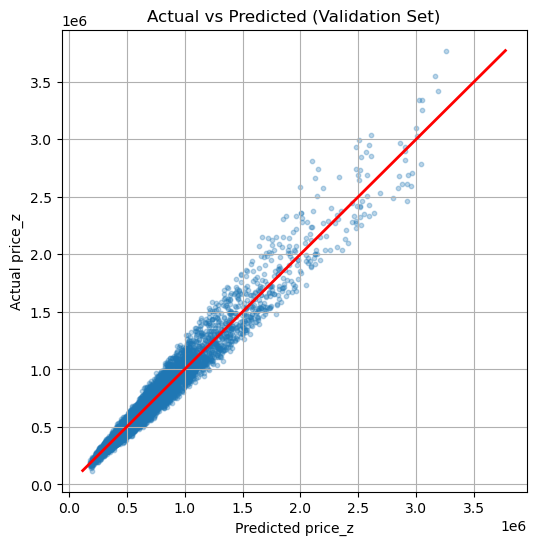

In [55]:
# Scatter plot: Actual vs Predicted
plt.figure(figsize=(6, 6))
plt.scatter(val_eda_df['predicted'], val_eda_df['actual'], alpha=0.3, s=10)
plt.plot([val_eda_df['actual'].min(), val_eda_df['actual'].max()],
         [val_eda_df['actual'].min(), val_eda_df['actual'].max()],
         color='red', linewidth=2)
plt.title('Actual vs Predicted (Validation Set)')
plt.xlabel('Predicted price_z')
plt.ylabel('Actual price_z')
plt.grid(True)
plt.show()

##### Residuals cluster around zero but widen for higher predicted values, this indicates some heteroscedasticity: large apartments tend to have larger errors, the bulk of points follow the 45° line, confirming decent overall fit.


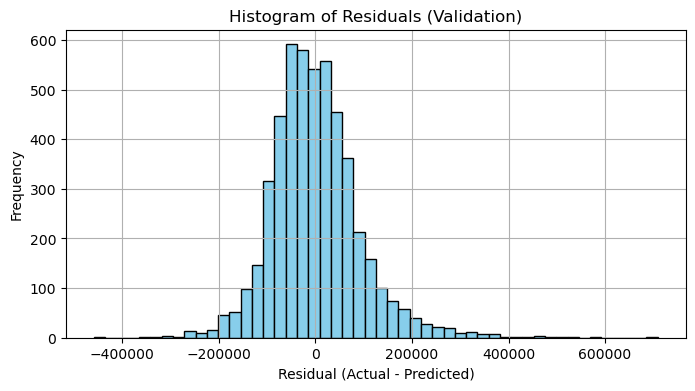

In [58]:
# Histogram of residuals
plt.figure(figsize=(8, 4))
plt.hist(val_eda_df['residual'], bins=50, color='skyblue', edgecolor='black')
plt.title('Histogram of Residuals (Validation)')
plt.xlabel('Residual (Actual - Predicted)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

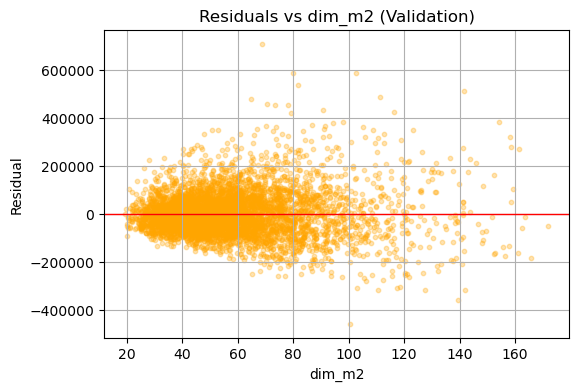

In [61]:
# Residuals vs dim_m2
plt.figure(figsize=(6, 4))
plt.scatter(val_eda_df['dim_m2'], val_eda_df['residual'], alpha=0.3, s=10, color='orange')
plt.axhline(0, color='red', linewidth=1)
plt.title('Residuals vs dim_m2 (Validation)')
plt.xlabel('dim_m2')
plt.ylabel('Residual')
plt.grid(True)
plt.show()

##### The residuals are roughly centered at zero with a slight right skew, most errors lie between –100k and +100k, but a long tail suggests occasional large underpredictions, the lack of a heavy left tail indicates fewer extreme overpricing errors.

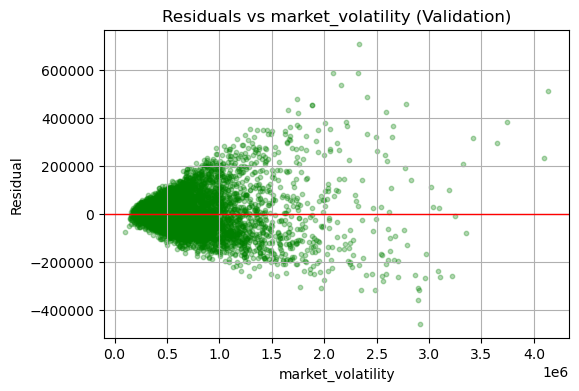

In [67]:
# Residuals vs market_volatility 
plt.figure(figsize=(6, 4))
plt.scatter(val_eda_df['market_volatility'], val_eda_df['residual'], alpha=0.3, s=10, color='green')
plt.axhline(0, color='red', linewidth=1)
plt.title('Residuals vs market_volatility (Validation)')
plt.xlabel('market_volatility')
plt.ylabel('Residual')
plt.grid(True)
plt.show()

##### Error magnitude increases with dim_m2, confirming heteroscedasticity. Smaller apartments (≤ 30 m²) cluster with lower residuals (~±50 k), whereas larger units (≥ 100 m²) frequently exceed ±150 k, this suggests a potential benefit from size-based segmentation.

<Figure size 600x400 with 0 Axes>

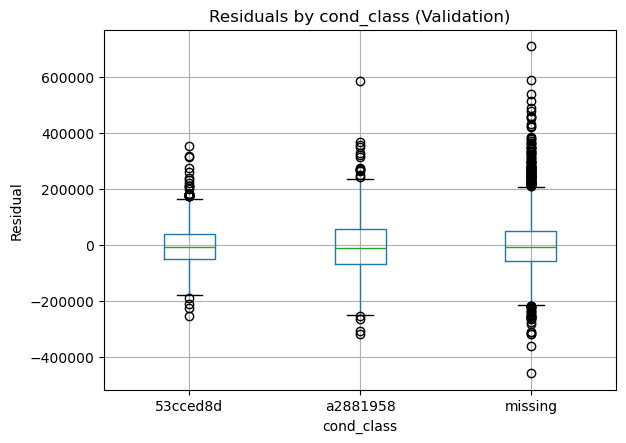

In [69]:
# Boxplot of residuals by cond_class (if cond_class exists)
plt.figure(figsize=(6, 4))
val_eda_df.boxplot(column='residual', by='cond_class')
plt.title('Residuals by cond_class (Validation)')
plt.suptitle('')
plt.xlabel('cond_class')
plt.ylabel('Residual')
plt.grid(True)
plt.show()

##### December 2023 and March/April 2024 show wider residual distributions, in those months, residuals span roughly –100 k to +200 k, indicating market volatility, other months (e.g., Aug/Sept 2023) have tighter residuals (±75 k), this aligns with the higher RMSE we saw for those volatile months.


In [71]:
# first few rows of predictions and residuals
display(val_eda_df.head(10))


,unit_id,dim_m2,n_rooms,floor_no,floor_max,year_built,dist_centre,n_poi,dist_sch,dist_clinic,...,log_dist_post,log_dist_kind,log_dist_rest,log_dist_uni,log_dist_pharma,actual,predicted,residual,month,size_bin
115300,de0ac808ffa7d150,53.11,3.0,2.0,3.0,2011.0,5.424,5.0,0.392,1.402,...,0.168054,0.306013,0.198851,1.273126,0.640274,656986.63,7.076502e+05,-50663.529649,2023-10-01,"(50, 70]"
40862,221add4ac342eda7,61.20,2.0,1.0,2.0,1970.0,9.588,0.0,1.398,1.615,...,0.813593,0.981704,0.880456,NaN,0.831604,339294.01,3.714411e+05,-32147.059897,2024-01-01,"(50, 70]"
20381,ee5692d61189003c,75.34,4.0,3.0,4.0,1952.0,0.201,148.0,0.274,0.274,...,0.180653,0.273076,0.011929,0.248421,0.075107,1365097.74,1.507271e+06,-142173.576366,2024-03-01,"(70, 100]"
139584,bf4fcd65f25aad2d,56.34,3.0,2.0,5.0,2012.0,4.219,11.0,0.177,0.989,...,0.459322,0.181488,0.225541,1.198156,0.031499,711241.87,7.248904e+05,-13648.542977,2024-05-01,"(50, 70]"
30081,450b8b810be4aac8,47.27,3.0,2.0,2.0,1933.0,8.403,17.0,0.246,0.984,...,0.506215,0.199670,0.209450,0.880042,0.190620,884999.97,7.640268e+05,120973.166868,2024-04-01,"(30, 50]"
48114,144cbd107da687ca,71.96,3.0,3.0,5.0,1958.0,1.365,34.0,0.303,0.160,...,0.276115,0.300105,0.180653,0.260825,0.042101,535112.01,5.754475e+05,-40335.480855,2023-10-01,"(70, 100]"
105181,d3337e1e9550c133,67.05,4.0,3.0,3.0,1990.0,3.990,0.0,2.660,3.716,...,1.499623,1.506075,1.286750,1.371434,1.276479,644443.46,5.371402e+05,107303.244892,2024-03-01,"(50, 70]"
27287,78a0ac48915a9f5b,43.34,2.0,4.0,4.0,1971.0,2.885,10.0,0.322,0.313,...,0.568151,0.183155,0.495915,0.597737,0.276115,812332.58,7.886852e+05,23647.423371,2024-02-01,"(30, 50]"
108419,de994d2a2ec7b8fc,68.21,3.0,1.0,4.0,1994.0,9.301,10.0,0.197,1.142,...,0.360468,0.283674,0.157858,1.072953,0.225541,881668.79,7.564910e+05,125177.817352,2024-06-01,"(50, 70]"
31612,10be1c6ceff5f7ea,52.89,2.0,3.0,3.0,2011.0,5.901,14.0,0.605,0.594,...,0.127513,0.044017,0.028587,0.590561,0.177309,683397.74,6.878782e+05,-4480.436046,2024-01-01,"(50, 70]"
